Importujemy potrzebne biblioteki oraz ustawiamy ilość testów

In [37]:
#Zastosowane w piewszym i drugim modelu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

num_of_experiments = 5

Wczytujemy dane z plików "horseColicTraining" oraz "horseColicTest" i zapisujemy je w zmiennych trainingSet, trainingLabels oraz testSet, testLabels. Tworzymy listy do przechowywania dokładności modeli.

In [38]:
# Funkcja wczytująca dane z pliku "file_name", zapisuje dane w zmiennych "data_set" (cechy) i "data_labels" (etykiety)
def load_data(file_name):
    data_set = []
    data_labels = []
    with open(file_name) as fr:
        for line in fr.readlines():
            curr_line = line.strip().split('\t') # Rozdzielamy dane na kolumny (dane oddzielone tabulatorem)
            line_arr = [float(curr_line[i]) for i in range(21)]  # Pierwsze 21 kolumn to cechy
            data_set.append(line_arr) # Dodajemy cechy do data_set
            data_labels.append(float(curr_line[21]))  # 22 kolumna to etykiety. Dodajemy etykiety do data_labels
    return np.array(data_set), np.array(data_labels)

# Wczytujemy zestawy danych treningowych i testowych
trainingSet, trainingLabels = load_data('horseColicTraining.txt')
testSet, testLabels = load_data('horseColicTest.txt')

accuracy_logreg = []
accuracy_log = []
accuracy_tree = []

Tworzymy funkcje do generowania także dane, aby przeprowadzić na nich testy. Tworzymy listy do przechowywania dokładności modeli.

In [39]:
def generate_synthetic_data(n_samples=500, n_features=5):
    X = np.random.rand(n_samples, n_features)
    y = np.random.randint(0, 2, size=n_samples) 
    return X, y

accuracy_logreg_synthetic = []
accuracy_log_synthetic = []
accuracy_tree_synthetic = []

Zaimplementowanie modelu regresji logistycznej na przykładzie podanym na https://github.com/pbharrin/machinelearninginaction

In [40]:
# Funkcja sigmoid — oblicza prawdopodobieństwo na podstawie funkcji logistycznej
def sigmoid(inX):
    return 1.0 / (1 + np.exp(-inX)) # Funkcja logistyczna, która zwraca wartości w przedziale (0, 1)

# Funkcja klasyfikująca wektor cech na podstawie wagi modelu
def classifyVector(inX, weights):
    prob = sigmoid(sum(inX * weights)) # Obliczamy prawdopodobieństwo
    return 1.0 if prob > 0.5 else 0.0 # Zwracamy 1.0 jeśli prawdopodobieństwo > 0.5, w przeciwnym razie 0.0

def LogRegress(dataMatrix, classLabels, numIter=150, learning_rate=0.001):
    m, n = np.shape(dataMatrix) # m — liczba próbek, n — liczba cech
    weights = np.ones(n)   #  Inicjalizujemy wagi na wartość 1
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m): # Dla każdej próbki
            alpha = learning_rate / (1.0 + j + i) + 0.0001
            randIndex = int(np.random.uniform(0, len(dataIndex)))  
            h = sigmoid(sum(dataMatrix[randIndex] * weights)) # Obliczamy prawdopodobieństwo przy użyciu funkcji sigmoid
            error = classLabels[randIndex] - h
            weights = weights + alpha * error * dataMatrix[randIndex]
            del(dataIndex[randIndex])  # Usuwamy użyty indeks, by nie powtarzać tej samej próbki
    return weights

Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na "przetasowanych" danych HorseColic oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

In [41]:
accuracy_logreg = []
accuracy_log = []
accuracy_tree = []
    
# Lists to collect all predictions from every experiment
all_predictions_logreg = []
all_predictions_log = []
all_predictions_tree = []

def MultiTestHorse(num_experiments):
    for i in range(num_experiments):
        # Shuffle and split the training set randomly
        indices = np.random.permutation(len(trainingSet))
        shuffled_trainingSet = trainingSet[indices]
        shuffled_trainingLabels = trainingLabels[indices]
        
        # Train custom Logistic Regression model
        trainWeights = LogRegress(shuffled_trainingSet, shuffled_trainingLabels, 1000, 0.01)
        predictions_logreg_probs = [classifyVector(sample, trainWeights) for sample in testSet]
        predictions_logreg = [1 if prob >= 0.5 else 0 for prob in predictions_logreg_probs]
        all_predictions_logreg.extend(predictions_logreg)  # Collect all predictions
        acc_logreg = accuracy_score(testLabels, predictions_logreg)
        accuracy_logreg.append(acc_logreg)

        # Train Scikit-Learn's Logistic Regression model
        log_model = LogisticRegression(max_iter=5000)
        log_model.fit(shuffled_trainingSet, shuffled_trainingLabels)
        predictions_log_probs = log_model.predict_proba(testSet)[:, 1]
        predictions_log = [1 if prob >= 0.5 else 0 for prob in predictions_log_probs]
        all_predictions_log.extend(predictions_log)  # Collect all predictions
        acc_log = accuracy_score(testLabels, predictions_log)
        accuracy_log.append(acc_log)

        # Train Decision Tree Classifier
        tree_model = DecisionTreeClassifier()
        tree_model.fit(shuffled_trainingSet, shuffled_trainingLabels)
        predictions_tree_probs = tree_model.predict_proba(testSet)[:, 1]
        predictions_tree = [1 if prob >= 0.5 else 0 for prob in predictions_tree_probs]
        all_predictions_tree.extend(predictions_tree)  # Collect all predictions
        acc_tree = accuracy_score(testLabels, predictions_tree)
        accuracy_tree.append(acc_tree)

   
# Run the function with 5 experiments
MultiTestHorse(num_of_experiments)

Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na wygenerowanych danych oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

In [47]:
# Lists to collect all accuracies
accuracy_logreg_synthetic = []
accuracy_log_synthetic = []
accuracy_tree_synthetic = []

# Lists to collect all predictions from every experiment
all_predictions_logreg_synthetic = []
all_predictions_log_synthetic = []
all_predictions_tree_synthetic = []



def MultiTestSynth(num_experiments):


    for i in range(num_experiments):
        # Generate synthetic dataset
        synthetic_X, synthetic_y = generate_synthetic_data()
        
        # Split synthetic data into training and testing (80/20 split)
        split_index = int(0.8 * len(synthetic_X))
        X_train, X_test = synthetic_X[:split_index], synthetic_X[split_index:]
        y_train, y_test = synthetic_y[:split_index], synthetic_y[split_index:]

        # Train custom Logistic Regression model
        trainWeights = LogRegress(X_train, y_train, 1000, 0.01)
        predictions_logreg = [classifyVector(sample, trainWeights) for sample in X_test]
        all_predictions_logreg_synthetic.extend(predictions_logreg)  # Collect all predictions
        acc_logreg = accuracy_score(y_test, predictions_logreg)
        accuracy_logreg_synthetic.append(acc_logreg)

        # Train Scikit-Learn's Logistic Regression model
        log_model = LogisticRegression(max_iter=2000)  # Increased iterations for convergence
        log_model.fit(X_train, y_train)
        predictions_log = log_model.predict(X_test)
        all_predictions_log_synthetic.extend(predictions_log)  # Collect all predictions
        acc_log = accuracy_score(y_test, predictions_log)
        accuracy_log_synthetic.append(acc_log)

        # Train Decision Tree Classifier
        tree_model = DecisionTreeClassifier()
        tree_model.fit(X_train, y_train)
        predictions_tree = tree_model.predict(X_test)
        all_predictions_tree_synthetic.extend(predictions_tree)  # Collect all predictions
        acc_tree = accuracy_score(y_test, predictions_tree)
        accuracy_tree_synthetic.append(acc_tree)

    return y_test

y_test = MultiTestHorse(num_of_experiments)

Wyświetlanie wykresów Dokładności i Ground Truth dla danych HorseColic

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

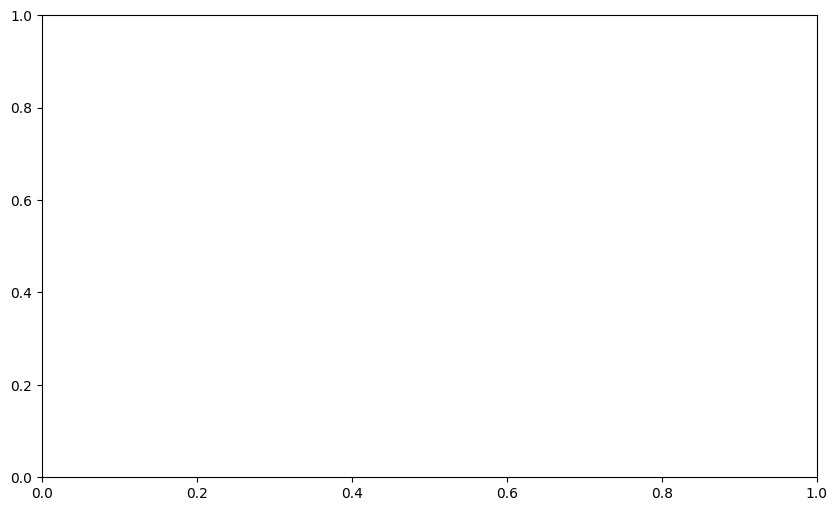

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_of_experiments), accuracy_logreg, marker='o', label="LogRegress (Synthetic)")
plt.plot(range(num_of_experiments), accuracy_log, marker='D', label="Logistic Regression (Synthetic)")
plt.plot(range(num_of_experiments), accuracy_tree, marker='s', label="Decision Tree (Synthetic)")
plt.xlabel("Experiment Number")
plt.ylabel("Accuracy")
plt.title("Model Performance on Synthetic Data")
plt.legend()
plt.grid(True)
plt.show()

# Print average accuracies
print("\nAverage Accuracy of Custom Logistic Regression: {:.2f}%".format(np.mean(accuracy_logreg) * 100))
print("Average Accuracy of Logistic Regression (Scikit-Learn): {:.2f}%".format(np.mean(accuracy_log) * 100))
print("Average Accuracy of Decision Tree Classifier: {:.2f}%".format(np.mean(accuracy_tree) * 100))

    # Function to calculate and plot the adjusted deviations
true_labels = testLabels  # Replace with your actual ground truth labels
all_predictions = [all_predictions_logreg, all_predictions_log, all_predictions_tree]  # Replace with your predictions
labels = ["Custom Logistic Regression", "Logistic Regression (Scikit-Learn)", "Decision Tree"]
title = "Ground Truth vs Model Predictions Adjusted Deviation"

# Plotting adjusted deviations
plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue']  # Colors for each model

for predictions, label, color in zip(all_predictions, labels, colors):
    # Calculate deviations: 1 for over-predictions, -1 for under-predictions, 0 for correct predictions
    deviations = [1 if pred > true else -1 if pred < true else 0 for true, pred in zip(true_labels, predictions)]
    plt.plot(deviations, marker='o', linestyle='', label=f'{label} Deviations', alpha=0.7, color=color)

plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline for no deviation
plt.title(f'{title} - Adjusted Deviation Plot')
plt.xlabel('Sample Index')
plt.ylabel('Deviation (1: Over-prediction, -1: Under-prediction, 0: Correct)')
plt.legend()
plt.grid(True)
plt.show()



Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na wygenerowanych danych oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

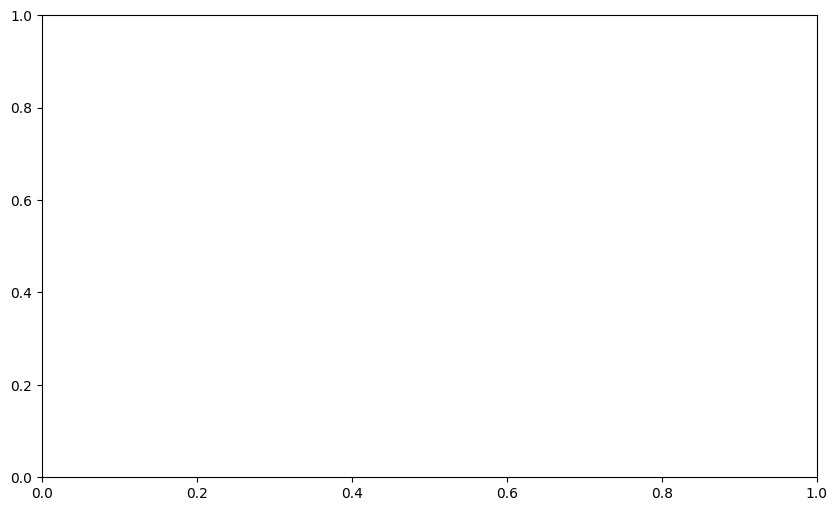

In [49]:


plt.figure(figsize=(10, 6))
plt.plot(range(num_of_experiments), accuracy_logreg_synthetic, marker='o', label="LogRegress (Synthetic)")
plt.plot(range(num_of_experiments), accuracy_log_synthetic, marker='D', label="Logistic Regression (Synthetic)")
plt.plot(range(num_of_experiments), accuracy_tree_synthetic, marker='s', label="Decision Tree (Synthetic)")
plt.xlabel("Experiment Number")
plt.ylabel("Accuracy")
plt.title("Model Performance on Synthetic Data")
plt.legend()
plt.grid(True)
plt.show()

print("\nAverage Accuracy on Synthetic Data - Logistic Regression: {:.2f}%".format(np.mean(accuracy_logreg_synthetic) * 100))
print("Average Accuracy on Synthetic Data - Logistic Regression (SCKIT-LEARN): {:.2f}%".format(np.mean(accuracy_log_synthetic) * 100))
print("Average Accuracy on Synthetic Data - Decision Tree (SCKIT-LEARN): {:.2f}%".format(np.mean(accuracy_tree_synthetic) * 100))

# Sample data
true_labels = y_test  # Replace with your actual ground truth labels
all_predictions = [all_predictions_logreg_synthetic, all_predictions_log_synthetic, all_predictions_tree_synthetic]
labels = ["Custom Logistic Regression", "Logistic Regression (SCIKIT-LEARN)", "Decision Tree (SCIKIT-LEARN)"]
title = "Ground Truth vs Model Predictions Adjusted Deviation"

# Plotting adjusted deviations
plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue']  # Colors for each model

for predictions, label, color in zip(all_predictions, labels, colors):
    # Calculate deviations: 1 for over-predictions, -1 for under-predictions, 0 for correct predictions
    deviations = [1 if pred > true else -1 if pred < true else 0 for true, pred in zip(true_labels, predictions)]
    plt.plot(deviations, marker='o', linestyle='', label=f'{label} Deviations', alpha=0.7, color=color)

plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline for no deviation
plt.title(f'{title} - Adjusted Deviation Plot')
plt.xlabel('Sample Index')
plt.ylabel('Deviation (1: Over-prediction, -1: Under-prediction, 0: Correct)')
plt.legend()
plt.grid(True)
plt.show()
